# Convolutional Neural Network

Computer vision is a machine learning technique used to solve problems (find patterns) that involve images and one of these techniques is called CNN. Not all problems are the same and just like in the <a href="https://github.com/4igeek/TensorFlow/tree/main/Classification">classification section</a> of this project we saw two kinds of problems:

1) Binary class problems
2) Multi-class problems

## Typical architecture for a CNN

<table style="width:100%">
    <thead>
        <tr>
            <th style="width:15%">Layer type</th>
            <th style="width:35%">What it does</th>
            <th style="width:50%">Default values</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Input layer</td>
            <td>Processes input images (in the form of tensors)</td>
            <td>Input shape = (batch_size, image_height, image_width, color_channels)</td>
        </tr>
        <tr>
            <td>Convolution layer</td>
            <td>Extracts the key features from images</td>
            <td><span style="font-family: Consolas;">tf.keras.layers.convXD</span>- where X can be any number i.e. 1 for text or 2 for img.</td>
        </tr>
        <tr>
            <td>Hidden activation</td>
            <td>Adds non-linearity to the extracted features</td>
            <td>Usually reLU <span style="font-family: Consolas;">tf.keras.activations.relu</span></td>
        </tr>
        <tr>
            <td>Pooling layer</td>
            <td>Reduces dimensionality of the extracted features</td>
            <td>
            Avg: <span style="font-family: Consolas;">tf.keras.layers.AvgPool2D</span> or 
            Max: <span style="font-family: Consolas;">tf.keras.layers.MaxPool2D</span>
            </td>
        </tr>
        <tr>
            <td>Fully connected layer</td>
            <td>Refines features passed by convolution layers   </td>
            <td><span style="font-family: Consolas;">tf.keras.layers.Dense</span></td>
        </tr>
        <tr>
            <td>Output layer</td>
            <td>Takes learned features and outputs labels</td>
            <td>Output shape = [number_of_classes]</td>
        </tr>
        <tr>
            <td>Output activation</td>
            <td>Adds non-linearity to output layer</td>
            <td>
            Binary: <span style="font-family: Consolas;">tf.keras.activations.sigmoid</span>
            or   
            Multi-class: <span style="font-family: Consolas;">tf.keras.activations.softmax</span>
            </td>
        </tr>
    </tbody>
</table>

There are a lot of ways (almost unlimited) you could make a CNN model. Usually you have a "pooling layer" follow a "conv2D layer" and you may have a number of pooling and conv2D layers stacked on top of one another (in a single model).

## Getting some data

We're going to use kaggle.com to get a dataset for the next notebook. We're going to use the Food 101 dataset. The dataset has been modified to only include two classes i.e pizza and steak. The reason this has been done (and we're not just going in with the 101 different classes) is so we can get a working/proven model before giving it more data (as the more data, the longer it takes to train etc).

As soon as we are happy with our solution we can then scale up and add more classes. We're going to focus on starting simple and then adding complexity (something we should do often when solving ML problems).

In [1]:
import tensorflow as tf

In [2]:
# We're going to "wget" the required zip file and then we're going to extract the data from the zip file.
import zipfile

!wget -q https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip # -q to suppress output

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

## Taking a look at the data

It's really important to have a look at the data before moving on to trying to solve the problem. For computer vision this usually involves looking at individual bits of data to get a feel for how the data is made up.

The first thing we may do is find out how many items of data we have in each of the various sets i.e. training (pizza & steak) and testing (pizza & steak). 

In [3]:
import os

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in 'pizza_steak'
There are 2 directories and 0 images in 'pizza_steak\test'
There are 0 directories and 250 images in 'pizza_steak\test\pizza'
There are 0 directories and 250 images in 'pizza_steak\test\steak'
There are 2 directories and 0 images in 'pizza_steak\train'
There are 0 directories and 750 images in 'pizza_steak\train\pizza'
There are 0 directories and 750 images in 'pizza_steak\train\steak'


We can see from the output above that we have 250 test images (each) of both steak and pizza and we have 750 training images (for each). So we have 1,000 images for both steak and pizza. We know at this point that we are going to have 2 class names i.e pizza and steak but we may get a dataset where we don't know the class labels.

The next thing we need to do is retrieve our list of class names.

In [15]:
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


## Visualising our data

The next step in looking at the data is to visualise some samples of data to see what we're dealing with.

In [16]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


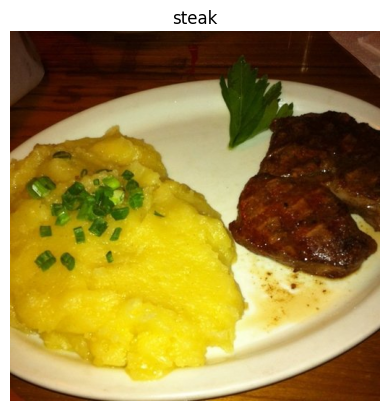

In [18]:
img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

## End-to-end example

We're going to build a CNN to find patterns in our images. We need to do the following:

- <span style="color:green;">Load the images</span>
- <span style="color:green;">Preprocess our images</span>
- Build a CNN model
- Compile the model
- Fit the model

In [19]:
# This is where we're going to preprocess our data (normalise and turn into "batches").
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

len(train_data) # There are 47 different batches each containing 32 images i.e. 1500 / 32 = 46.875 or 47

Found 1500 images belonging to 2 classes.


Found 500 images belonging to 2 classes.


47

In [20]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu"), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5


C:\Users\conta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.6368 - loss: 0.6201 - val_accuracy: 0.7440 - val_loss: 0.4976
Epoch 2/5


AttributeError: 'NoneType' object has no attribute 'items'